In [2]:
import keras
keras.__version__

'2.2.4'

In [3]:
import os

data_dir = 'jena_climate/'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


In [4]:
import numpy as np

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

In [5]:
float_data

array([[ 9.9652e+02, -8.0200e+00,  2.6540e+02, ...,  1.0300e+00,
         1.7500e+00,  1.5230e+02],
       [ 9.9657e+02, -8.4100e+00,  2.6501e+02, ...,  7.2000e-01,
         1.5000e+00,  1.3610e+02],
       [ 9.9653e+02, -8.5100e+00,  2.6491e+02, ...,  1.9000e-01,
         6.3000e-01,  1.7160e+02],
       ...,
       [ 9.9982e+02, -3.1600e+00,  2.7001e+02, ...,  1.0800e+00,
         2.0000e+00,  2.1520e+02],
       [ 9.9981e+02, -4.2300e+00,  2.6894e+02, ...,  1.4900e+00,
         2.1600e+00,  2.2580e+02],
       [ 9.9982e+02, -4.8200e+00,  2.6836e+02, ...,  1.2300e+00,
         1.9600e+00,  1.8490e+02]])

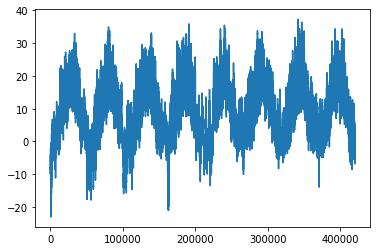

In [7]:
from matplotlib import pyplot as plt
%matplotlib inline

temp = float_data[:, 1]  # temperature (in degrees Celsius)
plt.plot(range(len(temp)), temp)
plt.show()

In [8]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

In [9]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

In [10]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

# This is how many steps to draw from `val_gen`
# in order to see the whole validation set:
val_steps = (300000 - 200001 - lookback) // batch_size

# This is how many steps to draw from `test_gen`
# in order to see the whole test set:
test_steps = (len(float_data) - 300001 - lookback) // batch_size


In [11]:
train_gen

<generator object generator at 0x7f7eea279db0>

In [12]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))
    
evaluate_naive_method()

0.2897359729905486


In [13]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/20
500/500 [==============================] - 15s 29ms/step - loss: 2.0384 - val_loss: 1.2293
Epoch 2/20
500/500 [==============================] - 8s 17ms/step - loss: 0.7551 - val_loss: 0.4215
Epoch 3/20
500/500 [==============================] - 8s 17ms/step - loss: 0.3467 - val_loss: 0.3051
Epoch 4/20
500/500 [==============================] - 9s 18ms/step - loss: 0.2810 - val_loss: 0.3457
Epoch 5/20
500/500 [==============================] - 9s 18ms/step - loss: 0.2610 - val_loss: 0.3204
Epoch 6/20
500/500 [==============================] - 8s 17ms/step - loss: 0.2482 - val_loss: 0.3116
Epoch 7/20
500/500 [==============================] - 9s 17ms/step - loss: 0.2411 - val_loss: 0.3112
Epoch 8/20
500/500 [==============================] - 8s 17ms/step - loss: 0.2339 - val_loss: 0.3206
Epoch 9/20
500/500 [==============================] - 9s 18ms/step - lo

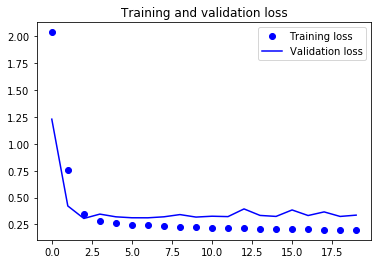

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 141s 283ms/step - loss: 0.3047 - val_loss: 0.2700
Epoch 2/20
500/500 [==============================] - 132s 263ms/step - loss: 0.2853 - val_loss: 0.2664
Epoch 3/20
500/500 [==============================] - 132s 264ms/step - loss: 0.2799 - val_loss: 0.2633
Epoch 4/20
500/500 [==============================] - 133s 265ms/step - loss: 0.2722 - val_loss: 0.2649
Epoch 5/20
500/500 [==============================] - 130s 261ms/step - loss: 0.2662 - val_loss: 0.2627
Epoch 6/20
500/500 [==============================] - 129s 257ms/step - loss: 0.2607 - val_loss: 0.2628
Epoch 7/20
500/500 [==============================] - 132s 263ms/step - loss: 0.2548 - val_loss: 0.2672
Epoch 8/20
500/500 [==============================] - 131s 262ms/step - loss: 0.2501 - val_loss: 0.2755
Epoch 9/20
500/500 [==============================] - 129s 257ms/step - loss: 0.2464 - val_loss: 0.2717
Epoch 10/20
500/500 [==============================] - 132s 265m

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()